# **Deteksi hama dan penyakit tanaman hortikultura menggunakan metode LSTM**
Class : KentangSehat, KentangEarlyBlight, KentangLateBlight, TomatSehat, TomatSpiderMite, TomatWhiteFly

---
# 🌻 **Menyiapkan Library**
---

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LSTM, Dense, Input, Flatten, TimeDistributed, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report

---
# 🌻 **Proses Dataset**
---
Drive dataset (80:20) ✏ https://drive.google.com/drive/folders/12D81qog6z5i74q9pRgktE3RNkfJrgVIZ?usp=drive_link

Drive dataset (70:30) ✏ https://drive.google.com/drive/folders/1w1bH8hcvdob6gppsRcpkmoCUsXj09PGY?usp=drive_link

Drive dataset (60:40) ✏ https://drive.google.com/drive/folders/1S7RaIPreSq5ULIzJLSlcgyTc25o4skVS?usp=drive_link

Drive dataset (50:50) ✏ https://drive.google.com/drive/folders/1x4WVbLydY8neWKzOxiJnAHOFyhSEA_wt?usp=drive_link

In [2]:
# Paths
train_dir = "dataset8-2/train"
test_dir = "dataset8-2/test"

# Tentukan parameter
img_size = 224 
batch_size = 32   

# Augmentasi Data dengan ImageDataGenerator
# a. Augmentasi untuk Dataset Pelatihan (train_datagen)
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,            # Normalisasi nilai piksel
    rotation_range=360,           # Rotasi acak antara 0 hingga 360 derajat
    width_shift_range=0.2,        # Pergeseran horizontal acak sebesar 20% dari lebar gambar
    height_shift_range=0.2,       # Pergeseran vertikal acak sebesar 20% dari tinggi gambar
    shear_range=0.2,              # Transformasi shear acak
    zoom_range=0.2,               # Zoom in/out secara acak
    # horizontal_flip=True,       # Pembalikan secara horizontal
    # vertical_flip=True,         # Pembalikan secara vertikal (berguna jika orientasi daun tidak tetap)
    brightness_range=(0.5, 1.5),  # Variasi kecerahan antara 50% hingga 150%
    fill_mode="nearest",          # Strategi pengisian piksel setelah transformasi
)

# b. Augmentasi untuk Dataset Validasi (test_datagen)
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,          # Small rotations to simulate different angles
    width_shift_range=0.1,      # Small horizontal shifts
    height_shift_range=0.1,     # Small vertical shifts
    brightness_range=(0.8, 1.2) # Slightly adjust brightness
)

# Memuat Dataset ke dalam Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

# Menampilkan Daftar Kelas
classes = list(train_generator.class_indices.keys())
print(classes)
class_count = len(classes)

Found 4800 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.
['KentangEarlyBlight', 'KentangLateBlight', 'KentangSehat', 'TomatSehat', 'TomatSpiderMite', 'TomatWhiteFly']


In [3]:
# Load pretrained CNN (MobileNetV2)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Add a Global Average Pooling layer
feature_extractor = Sequential([
    base_model,
    GlobalAveragePooling2D()
])
feature_extractor.trainable = False

---
# 🌻 **Cluster gambar menggunakan K-Means**
---

c:\Users\INTAN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step


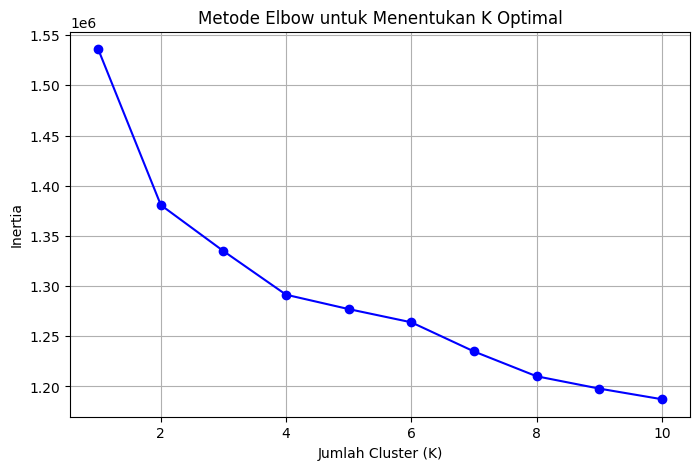

In [4]:
# Misalnya data latihnya bernama `X` (fitur numerik)
features = feature_extractor.predict(test_generator, verbose=1)

# Simpan sebagai X
X = features  # bentuknya sudah (jumlah_data, fitur)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Menentukan nilai inertia untuk berbagai nilai K
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot metode Elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Inertia')
plt.title('Metode Elbow untuk Menentukan K Optimal')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 

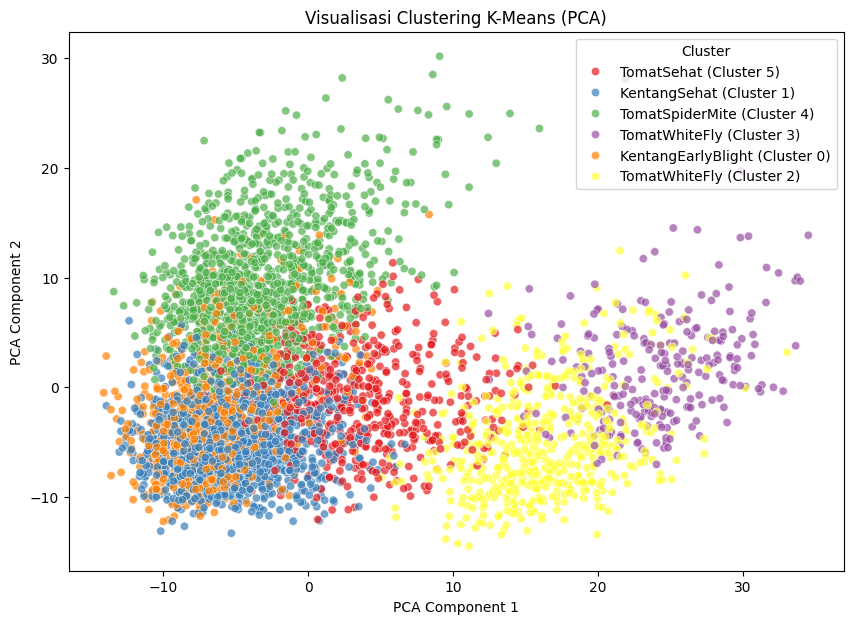

In [5]:
from collections import Counter

# Ekstraksi fitur dari gambar training
def extract_features(generator, model):
    features = []
    labels = []
    for batch_images, batch_labels in generator:
        batch_features = model.predict(batch_images)
        features.append(batch_features)
        labels.extend(np.argmax(batch_labels, axis=1))
        if len(features) * generator.batch_size >= generator.n:
            break  # Stop jika sudah semua data diambil
    return np.vstack(features), np.array(labels)

# Ekstrak fitur dari dataset training
train_features, train_labels = extract_features(train_generator, feature_extractor)

# Normalisasi fitur
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)

# Clustering dengan K-Means
num_clusters = 6 # 6 Kelas sesuai permintaan
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(train_features_scaled)
cluster_labels = kmeans.labels_

# Ambil daftar nama kelas dari train_generator
classes = list(train_generator.class_indices.keys())

# Buat mapping dari cluster ke kelas berdasarkan majority vote
cluster_to_class = {}
for cluster in range(num_clusters):
    indices = np.where(cluster_labels == cluster)[0]
    actual_classes = train_labels[indices]
    
    # Cari kelas yang paling dominan dalam cluster ini
    if len(actual_classes) > 0:
        most_common_class = Counter(actual_classes).most_common(1)[0][0]
        cluster_to_class[cluster] = classes[most_common_class]
    else:
        cluster_to_class[cluster] = "Unknown"  # Jika cluster kosong (tidak umum terjadi)

# Ganti label cluster dari angka ke nama kelas
cluster_names = np.array([f"{cluster_to_class[c]} (Cluster {c})" for c in cluster_labels])

# Simpan hasil clustering dengan nama kelas
np.save("cluster_names.npy", cluster_names)

print("Cluster mapping:")
print(cluster_to_class)
print("Clustering selesai dan hasil disimpan!")

# Visualisasi clustering dengan PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(train_features_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=cluster_names, palette='Set1', alpha=0.7)
plt.title('Visualisasi Clustering K-Means (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


---
# 🌻 **Membuat model LSTM**
---

https://www.youtube.com/watch?v=SEjhOSpYdZU

In [6]:
def sequence_generator(image_generator, sequence_length):
    while True:
        images, labels = next(image_generator)
        batch_size = images.shape[0]

        # Buat urutan dengan panjang sequence_length
        sequences = []
        new_labels = []

        for i in range(0, batch_size, sequence_length):
            sequence = images[i:i+sequence_length]
            if len(sequence) == sequence_length:
                sequences.append(sequence)
                new_labels.append(labels[i])  # Ambil label pertama untuk setiap urutan

        sequences = np.array(sequences)
        new_labels = np.array(new_labels)
        yield sequences, new_labels

sequence_length = 1  # Panjang urutan
train_sequence_generator = sequence_generator(train_generator, sequence_length)
test_sequence_generator = sequence_generator(test_generator, sequence_length)

In [7]:
# Buat model LSTM
model = Sequential([
    Input(shape=(sequence_length, img_size, img_size, 3)),
    TimeDistributed(feature_extractor),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 1, 1280)        │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,988,038 (11.40 MB)

 Trainable params: 730,054 (2.78 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

---
# 🌻 **Melatih model**
---


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Save the best model based on validation loss
checkpoint_best = ModelCheckpoint(
    'best_model.keras',         # File name for the best model
    monitor='val_loss',         # Metric to monitor
    save_best_only=True,        # Save only if val_loss improves
    verbose=1
)

# Save the model at the last epoch
checkpoint_last = ModelCheckpoint(
    'last_model.keras',         # File name for the last model
    monitor='epoch',            # Monitor epoch progression
    save_best_only=False,       # Save every epoch (ensuring the last one is saved)
    verbose=1
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate if validation loss stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

# List of callbacks
callbacks = [checkpoint_best, checkpoint_last, early_stopping, reduce_lr]

# Train the model
history = model.fit(
    train_sequence_generator,
    validation_data=test_sequence_generator,
    epochs=1,
    steps_per_epoch=len(train_generator) // sequence_length,
    validation_steps=len(test_generator) // sequence_length,
    callbacks=callbacks
)


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7605 - loss: 0.6877
Epoch 1: val_loss improved from inf to 0.18307, saving model to best_model.keras

Epoch 1: saving model to last_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.7612 - loss: 0.6856 - val_accuracy: 0.9333 - val_loss: 0.1831 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


---
# 🌻 **Menambahkan manual grid search dengan itertools lstm**
---

In [ ]:
import itertools
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, TimeDistributed, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Paths
train_dir = "dataset8-2/train"
test_dir = "dataset8-2/test"

# Hyperparameters
img_sizes = [128, 224, 256, 512]
batch_sizes = [16, 32, 64]
epochs_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
optimizers = {'adam': Adam, 'rmsprop': RMSprop, 'sgd': SGD}
sequence_length = 1

# Simpan hasil
results = []

# Data generator function for sequences
def sequence_generator(image_generator, sequence_length):
    while True:
        images, labels = next(image_generator)
        batch_size = images.shape[0]
        sequences, new_labels = [], []

        for i in range(0, batch_size, sequence_length):
            sequence = images[i:i+sequence_length]
            if len(sequence) == sequence_length:
                sequences.append(sequence)
                new_labels.append(labels[i])  # Label pertama dalam urutan

        yield np.array(sequences), np.array(new_labels)

# Loop kombinasi
for img_size, batch_size, opt_name, epoch in itertools.product(img_sizes, batch_sizes, optimizers.keys(), epochs_list):
    print(f"\n Training with: img_size={img_size}, batch_size={batch_size}, optimizer={opt_name}, epochs={epoch}")

    # Generator
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    train_sequence_generator = sequence_generator(train_generator, sequence_length)
    test_sequence_generator = sequence_generator(test_generator, sequence_length)

    # Base feature extractor
    feature_extractor = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
    feature_extractor.trainable = False

    # LSTM model
    model = Sequential([
        Input(shape=(sequence_length, img_size, img_size, 3)),
        TimeDistributed(feature_extractor),
        TimeDistributed(GlobalAveragePooling2D()),  # Tambahkan ini
        LSTM(128, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])
    
    # Pilih optimizer
    optimizer = optimizers[opt_name]()

    # Compile model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    callbacks = [
        ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    ]

    # Train model
    history = model.fit(
        train_sequence_generator,
        validation_data=test_sequence_generator,
        epochs=epoch,
        steps_per_epoch=len(train_generator) // sequence_length,
        validation_steps=len(test_generator) // sequence_length,
        callbacks=callbacks
    )

    # Ambil nilai akhir
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]

    # Simpan hasil
    results.append({
        'img_size': img_size,
        'batch_size': batch_size,
        'optimizer': opt_name,
        'epochs': epoch,
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'val_loss': val_loss
    })

# Urutkan berdasarkan akurasi validasi tertinggi
results_sorted = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

# Tampilkan hasil terbaik
best = results_sorted[0]
print("\n Hasil terbaik:")
print(best)


 Training with: img_size=128, batch_size=16, optimizer=adam, epochs=10
Found 4800 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8547 - loss: 0.4638
Epoch 1: val_loss improved from inf to 0.10562, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 145ms/step - accuracy: 0.8549 - loss: 0.4631 - val_accuracy: 0.9633 - val_loss: 0.1056 - learning_rate: 0.0010
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9768 - loss: 0.0637
Epoch 2: val_loss improved from 0.10562 to 0.10472, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 42s 140ms/step - accuracy: 0.9769 - loss: 0.0636 - val_accuracy: 0.9617 - val_loss: 0.1047 - learning_rate: 0.0010
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9902 - loss: 0.0330
Epoch 3: val_loss improved from 0.10472 to 0.09394, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 42s 140ms/st

In [ ]:
# Konversi hasil ke DataFrame
df_results = pd.DataFrame(results)

# Simpan ke CSV
#csv_path = "/content/drive/MyDrive/PA2 - Intan (6-6-2025)/training_results.csv"
csv_path = "training_results.csv"
df_results.to_csv(csv_path, index=False)

print(f"\nHasil percobaan telah disimpan ke: {csv_path}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load hasil percobaan dari CSV
df_results = pd.read_csv(csv_path)

# Plot distribusi akurasi berdasarkan ukuran gambar
plt.figure(figsize=(12, 6))
sns.boxplot(x="img_size", y="val_accuracy", data=df_results)
plt.title("Distribusi Akurasi Validasi Berdasarkan Ukuran Gambar")
plt.xlabel("Ukuran Gambar")
plt.ylabel("Akurasi Validasi")
plt.grid(True)
plt.show()

# Plot distribusi akurasi berdasarkan batch size
plt.figure(figsize=(12, 6))
sns.boxplot(x="batch_size", y="val_accuracy", data=df_results)
plt.title("Distribusi Akurasi Validasi Berdasarkan Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Akurasi Validasi")
plt.grid(True)
plt.show()

# Plot distribusi akurasi berdasarkan optimizer
plt.figure(figsize=(12, 6))
sns.boxplot(x="optimizer", y="val_accuracy", data=df_results)
plt.title("Distribusi Akurasi Validasi Berdasarkan Optimizer")
plt.xlabel("Optimizer")
plt.ylabel("Akurasi Validasi")
plt.grid(True)
plt.show()

# Tren akurasi terhadap jumlah epoch
plt.figure(figsize=(12, 6))
sns.lineplot(x="epochs", y="val_accuracy", data=df_results, marker="o")
plt.title("Tren Akurasi Validasi Berdasarkan Jumlah Epoch")
plt.xlabel("Jumlah Epoch")
plt.ylabel("Akurasi Validasi")
plt.grid(True)
plt.show()

---
# 🌻 **Evaluasi model**
---

In [ ]:
test_loss, test_acc = model.evaluate(
    sequence_generator(test_generator, sequence_length=sequence_length),
    steps=len(test_generator) // sequence_length  # Pastikan steps sesuai jumlah batch
)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

---
# 🌻 **Simpan model**
---

In [ ]:
# Simpan model lstm
model_path = "intanlstm_new.h5"
model.save(model_path)
print(f"Model saved to {model_path}")

---
# 🌻 **Visualisasi hasil**
---


* Menampilkan confusion matriks
* Menampilkan clasification report
* Menampilkan plot akurasi dan loss



In [ ]:
# Plot Akurasi dan Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy') # Changed 'test_accuracy' to 'val_accuracy'
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss') # Changed 'test_loss' to 'val_loss'
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
y_true = []
y_pred = []
processed_samples = 0
test_sequence_generator = sequence_generator(test_generator, sequence_length)

for batch_x, batch_y in test_sequence_generator:
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred_probs = model.predict(batch_x)
    y_pred.extend(np.argmax(y_pred_probs, axis=1))

    # Update the count of processed samples
    processed_samples += len(batch_x)

    # Exit the loop after processing all relevant samples
    if processed_samples >= len(test_generator.labels) - sequence_length + 1:
        break

# Confusion Matrix Heatmap
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Classification Report (includes precision, recall, and F1-score for each class)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Overall Metrics (weighted average across all classes)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the metrics
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

In [ ]:
# Predict labels for sampled images
sampled_images, true_labels = next(sequence_generator(test_generator, sequence_length=sequence_length))

# Calculate the number of rows and columns for subplots to accommodate all images
num_images = len(sampled_images)
num_cols = 6  # Number of columns (you can adjust this)
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows needed

plt.figure(figsize=(15, 15))
for i in range(num_images): # Iterate through all images
    plt.subplot(num_rows, num_cols, i + 1) # Use calculated rows and columns
    plt.imshow(sampled_images[i][0])
    plt.axis('off')

    # Predict the label for the current sequence
    predicted_label_index = np.argmax(model.predict(sampled_images[i].reshape(1, sequence_length, img_size, img_size, 3)))
    predicted_label = classes[predicted_label_index]
    true_label_index = np.argmax(true_labels[i]) # Assuming true_labels is one-hot encoded
    true_label = classes[true_label_index]
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)

plt.tight_layout()
plt.show()